# Gaussian process time profiles

I want to know if George has an edge over Martin's implimentation of a GP. I'll make one of each and test it against some dummy data to see if there's enough of a difference to warrant alterations.

In [1]:
import GaussianProcess as GP
import mcmcfit as mc
import numpy as np
np.random.seed(12345)

This is the GP initialiser from the GaussianProcess.py file. I copied it here, and modified it so that it doesn't need to calculate the changepoints or whatever, I just feed it the values. 

In [2]:
def createGP(changepoints, ampin, ampout, tau, phi):
    """Constructs a kernel, which is used to create Gaussian processes.

    Using values for the two hyperparameters (amp,tau), amp_ratio and dphi, this function:
    creates kernels for both inside and out of eclipse, works out the location of any
    changepoints present, constructs a single (mixed) kernel and uses this kernel to create GPs"""

    # Calculate kernels for both out of and in eclipse WD eclipse
    # Kernel inside of WD has smaller amplitude than that of outside eclipse,
    #k_in  = ampin*GP.ExpSquaredKernel(tau)
    #k_out  = ampout*GP.ExpSquaredKernel(tau)
    k_in  = ampin*GP.Matern32Kernel(tau)
    k_out = ampout*GP.Matern32Kernel(tau)
    #k_in  = ampin*GP.ExpKernel(tau)
    #k_out = ampout*GP.ExpKernel(tau)


    # Depending on number of changepoints, create kernel structure
    kernel_struc = [k_out]
    for k in range (int( phi.min() ), int( phi.max() )+1, 1):
        kernel_struc.append(k_in)
        kernel_struc.append(k_out)

    # Create kernel with changepoints
    kernel = GP.DrasticChangepointKernel(kernel_struc,changepoints)

    '''k1 = GP.Matern32Kernel(tau)

    gp_pars = np.array([ampout,ampin,ampout])
    changepoints = self.calcChangepoints(phi)

    k2 = GP.OutputScaleChangePointKernel(gp_pars,changepoints)

    kernel = k1*k2'''

    # Create GPs using this kernel
    gp = GP.GaussianProcess(kernel)
    return gp

I don't understand the `kernel_struc` part of the above. What is it's point? It seems to be used when we `compute`, but I don't get what it actually does. It looks like a weird way of being able to add the same kernel repeatedly?

I need to create some test data! Use something large, 2000 data, to get good timing info.

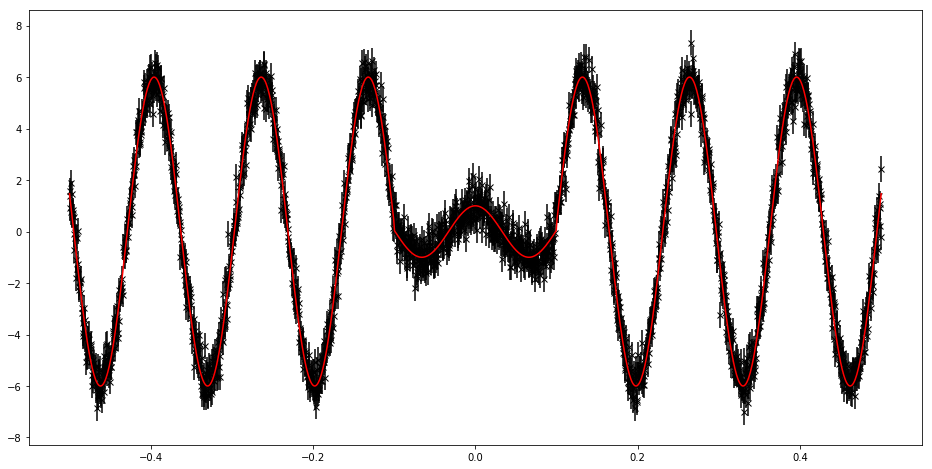

In [3]:
# These are the parameters of the '''real''' data. I'll use a cos wave, 
# with some point where the larger one is supressed.

actual_ampout = 5
actual_ampin  = 1
actual_tau    = 0.021

yerr = 0.5
N = 2000

actual_changepoints = [-0.1, 0.1]

temp = np.linspace(-0.5, 0.5, 100)

a = actual_ampout * np.cos(temp/actual_tau)
mask = np.abs(temp) > actual_changepoints[1]
a = a*mask

b = actual_ampin  * np.cos(temp/actual_tau)

c = a+b

ideal_x = np.linspace(-0.5, 0.5, 1000)
ideal_y = \
    (actual_ampout * np.cos(ideal_x/actual_tau)) * \
    (np.abs(ideal_x) > actual_changepoints[1]) + \
    (actual_ampin  * np.cos(ideal_x/actual_tau))

phi  = np.linspace(-0.5, 0.5, N)
data = np.interp(phi, temp, c) + ( yerr * np.random.randn(N) )
err  = yerr * np.ones_like(data)

fig, ax = plt.subplots(figsize=[16,8])
# ax.scatter(phi, a, color='red')
# ax.scatter(phi, b, color='green')
ax.errorbar(phi, data, yerr=err, marker='x', linestyle='', capsize=0, color='black', zorder=1)
ax.plot(ideal_x, ideal_y, color='red', zorder=10)
plt.show()

### The fun stuff

Now, I want to construct a version of Martin's GP. I'll use the actual values for now, so that I know it's fitting the right stuff (I only care about how long it takes, not how good it is for now)


In [4]:
def get_martin_samples():
    ampin  = actual_ampin
    ampout = actual_ampout
    tau    = actual_tau

    changepoints = actual_changepoints

    martinGP = createGP(changepoints, ampin, ampout, tau, phi)

    martinGP.compute(xp,ep)

    samples = martinGP.sample_conditional(yp, xp, size = 300)
    
    mu = np.mean(samples,axis=0)
    std = np.std(samples,axis=0)
    fmu, _ = martinGP.predict(yp, xf)

    return mu, std, fmu


Profiling how long it takes to initialise a GP and sample from it...
2.89 s ± 161 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


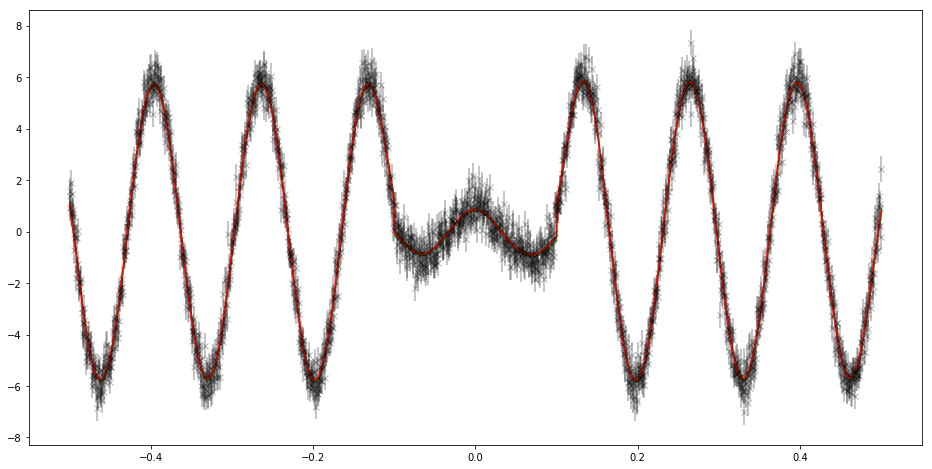

In [5]:
xp = phi.copy()
ep = err.copy()
yp = data.copy()

xf = np.linspace(xp.min(),xp.max(),1000)
wf = 0.5*np.mean(np.diff(xf))*np.ones_like(xf)
yf = np.interp(xf, xp, yp)

print("Profiling how long it takes to initialise a GP and sample from it...")
%timeit get_martin_samples()

mu, std, fmu = get_martin_samples()


fig, ax = plt.subplots(figsize=[16,8])

# data
ax.errorbar(phi, data, yerr=err, marker='x', linestyle='', capsize=0, color='black', alpha=0.3)
# GP result
ax.fill_between(xp, mu+std, mu-std, alpha=0.6, color='green')
ax.plot(xp, mu, color='red')

plt.show()

The timeit profile shows that, for a dataset of 2,000 points, computing takes $2.85\pm0.06$ seconds. This is pretty slow!

# Can we do better?


Now for the really fun part. I need to figure out how to do the same thing in George. 

In [6]:
import george as g

## George's implimentation

George seems to handle changepoints in a slightly different way. The kernels in George accept a two-value tuple, `block`, which limits the kernel to operating *within* the two values. Therefore, I only need three:
- One to operate from the beginning up to the first changepoint
- One to operate during the eclipse
- One to operate from the second changepoint to the end of the data

How hard can that be? First, I'll check that the kernels work as expected..

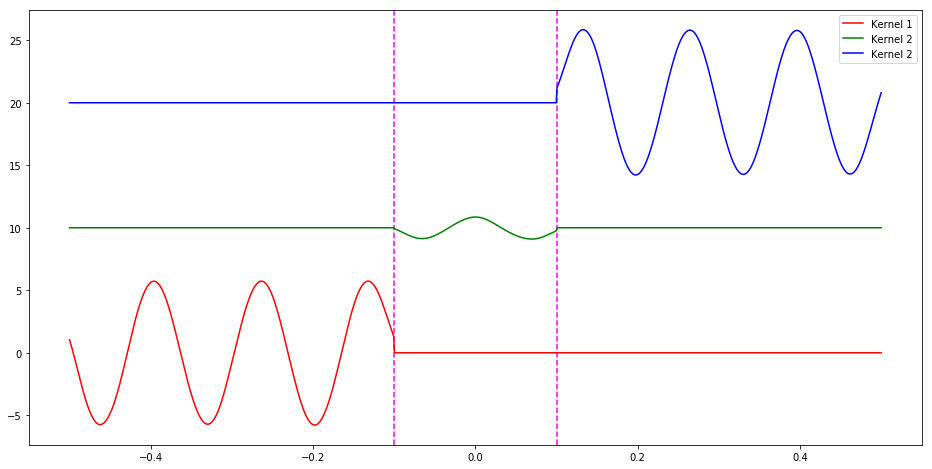

In [7]:
# I need three kernels:
# - One from the beginning to the first changepoint
# - One from the first changepoint to the second
# - One from the second changepoint to the end

# Get the true values
tau = actual_tau
ampin = actual_ampin
ampout = actual_ampout

changepoints = actual_changepoints

# The kernels cover this range:
# *****1*****-----2-----*****3*****
kernel1 = ampout * g.kernels.Matern32Kernel(tau, block=(-1, changepoints[0]) )
kernel2 = ampin  * g.kernels.Matern32Kernel(tau, block=changepoints          )
kernel3 = ampout * g.kernels.Matern32Kernel(tau, block=(changepoints[1],  1) )

# Add them together
kernel = kernel1 + kernel2 + kernel3

# Use that kernel to make a GP object
GP1 = g.GP(kernel1)
GP2 = g.GP(kernel2)
GP3 = g.GP(kernel3)

# Pre-compute the covariance matrix and factorize it for a set of times and uncertainties.
GP1.compute(xp, ep)
GP2.compute(xp, ep)
GP3.compute(xp, ep)

# Use the GP to predict the values of y at these x
yf_1, wf_1 = GP1.predict(yp, xf, return_var=True)
yf_2, wf_2 = GP2.predict(yp, xf, return_var=True)
yf_3, wf_3 = GP3.predict(yp, xf, return_var=True)

yf_2 += 10.
yf_3 += 20.

# Initialise plotting area
fig, ax = plt.subplots(figsize=[16,8])

## First kernel
ax.plot(xf, yf_1, color='red', zorder=10, label='Kernel 1')

## Second kernel
ax.plot(xf, yf_2, color='green', zorder=10, label='Kernel 2')

## Third kernel
ax.plot(xf, yf_3, color='blue', zorder=10, label='Kernel 2')

for c in actual_changepoints:
    ax.axvline(c, color='magenta', linestyle='--')

plt.legend()
plt.show()

Looks good to me!

In [8]:
def get_george_samples():
    # Get the true values
    tau = actual_tau
    ampin = actual_ampin
    ampout = actual_ampout

    changepoints = actual_changepoints

    # The kernels cover this range:
    # *****1*****-----2-----*****3*****
    kernel1 = ampout * g.kernels.Matern32Kernel(tau, block=(-1, changepoints[0]) )
    kernel2 = ampin  * g.kernels.Matern32Kernel(tau, block=changepoints          )
    kernel3 = ampout * g.kernels.Matern32Kernel(tau, block=(changepoints[1],  1) )

    # Add them together
    kernel = kernel1 + kernel2 + kernel3

    # Use that kernel to make a GP object
    georgeGP = g.GP(kernel)

    # Pre-compute the covariance matrix and factorize it for a set of times and uncertainties.
    georgeGP.compute(xp, ep)

    # Use the GP to predict the values of y at these x
    yf, wf = georgeGP.predict(yp, xf, return_var=True)

    return yf, wf

311 ms ± 6.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


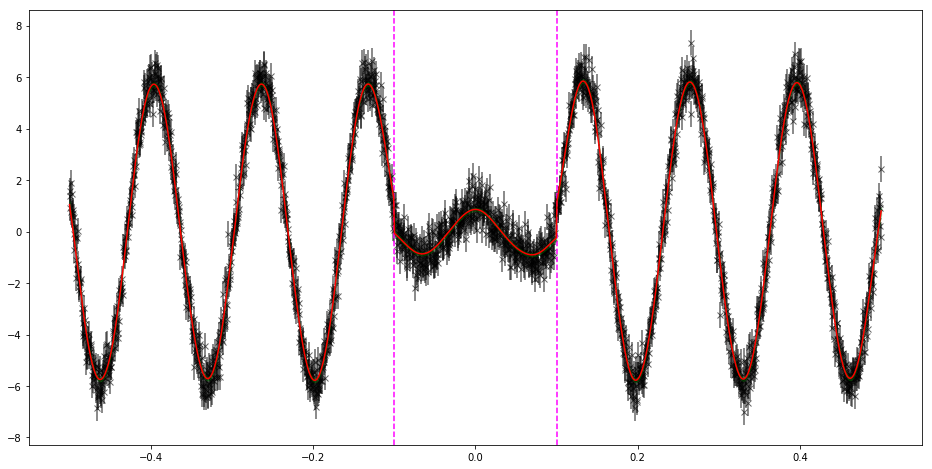

In [9]:
%timeit get_george_samples()
yf, wf = get_george_samples()

# Initialise plotting area
fig, ax = plt.subplots(figsize=[16,8])

# Plot the prediction variance
ax.fill_between(xf, yf+np.sqrt(wf), yf-np.sqrt(wf),
    alpha=0.3, color='green', zorder=9)
# Plot the prediction means
ax.plot(xf, yf, color='red', zorder=10)
# Plot the data
ax.errorbar(xp, yp, yerr=ep, marker='x', linestyle='', capsize=0, color='black', alpha=0.6, zorder=1)

for c in actual_changepoints:
    ax.axvline(c, color='magenta', linestyle='--')

plt.show()

This is *much* faster. $313\pm1$ms to do everything, from generating the kernel through to predicting the curve! 

# What about after the kernel generation? What's the bottleneck?

Now we know that george shows a substantial improvement over Martin's implimentation from a standing start, we want to double-check that the bottleneck isn't kernel generation, which only has to be dne every so often. 

## George:

In [10]:
# Get the true values
tau = actual_tau
ampin = actual_ampin
ampout = actual_ampout

changepoints = actual_changepoints

# The kernels cover this range:
# *****1*****-----2-----*****3*****
kernel1 = ampout * g.kernels.Matern32Kernel(tau, block=(-1, changepoints[0]) )
kernel2 = ampin  * g.kernels.Matern32Kernel(tau, block=changepoints          )
kernel3 = ampout * g.kernels.Matern32Kernel(tau, block=(changepoints[1],  1) )

# Add them together
kernel = kernel1 + kernel2 + kernel3

# Use that kernel to make a GP object
georgeGP = g.GP(kernel)

def test_george(georgeGP, xp, yp, ep, xf):
    # Pre-compute the covariance matrix and factorize it for a set of times and uncertainties.
    georgeGP.compute(xp, ep)

    # Use the GP to predict the values of y at these x
    yf, wf = georgeGP.predict(yp, xf, return_var=True)

    return yf, wf

%timeit yf, wf = test_george(georgeGP, xp, yp, ep, xf)

319 ms ± 8.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


$314\pm1$ms on my system, per compute/predict cycle.

## Martin:

In [11]:
ampin  = actual_ampin
ampout = actual_ampout
tau    = actual_tau

changepoints = actual_changepoints

martinGP = createGP(changepoints, ampin, ampout, tau, phi)

def test_martin(martinGP, xp, yp, ep, xf):
    martinGP.compute(xp,ep)

    samples = martinGP.sample_conditional(yp, xp, size = 300)
    
    mu = np.mean(samples,axis=0)
    std = np.std(samples,axis=0)
    fmu, _ = martinGP.predict(yp, xf)

    return mu, std, fmu

%timeit mu, std, fmu = test_martin(martinGP, xp, yp, ep, xf)

2.95 s ± 217 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As expected, the pattern holds. Based on this, I think it's *definitely* worth migrating over to george in handling our GP, and can expect an improvement in compute time of about a factor of 10.